In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [2]:
# Chargement et inspection des données
def load_data(train_path, test_path):
    # Charger les données d'entraînement
    with open(train_path, 'rb') as f:
        train_data = pickle.load(f)
    #print("Training data keys:", train_data.keys())  # Vérification des clés

    # Charger les données de test
    with open(test_path, 'rb') as f:
        test_data = pickle.load(f)
    #print("Test data keys:", test_data.keys())  # Vérification des clés

    # Identifier les clés correctes
    X_train = train_data.get('images')
    y_train = train_data.get('labels')
    X_test = test_data.get('images')

    if X_train is None or y_train is None or X_test is None:
        raise ValueError("Les données n'ont pas les bonnes clés. Vérifiez votre fichier pickle.")

    # Convertir en tableaux NumPy
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)

    return X_train, y_train, X_test

In [3]:
# Charger les données
train_path = 'train_data.pkl'
test_path = 'test_data.pkl'
X_train, y_train, X_test = load_data(train_path, test_path)

In [4]:
print(f"Shape of X_train is:{X_train.shape}")
print(f"Shape of y_train is:{y_train.shape}")
print(f"Shape of X_test is:{X_test.shape}")

Shape of X_train is:(97477, 28, 28)
Shape of y_train is:(97477,)
Shape of X_test is:(1000, 28, 28)


In [5]:
# Séparation des données
np.random.seed(42) # pour assurer la reproductibilité

# Mélanger les indices
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

# Calculer la taille de l'ensemble de test
test_size = 0.2 # 20% des données
test_size = int(X_train.shape[0] * test_size)

# Diviser les indices en indices d'entraînement et de validation
train_indices = indices[test_size:]
val_indices = indices[:test_size]

# Extraire les échantillons pour l'entraînement et la validation
X_train, X_val = X_train[train_indices], X_train[val_indices]
y_train, y_val = y_train[train_indices], y_train[val_indices]

print(f"Shape of X_train is:{X_train.shape}")
print(f"Shape of X_val is:{X_val.shape}")
print(f"Shape of y_train is:{y_train.shape}")
print(f"Shape of y_val is:{y_val.shape}")

Shape of X_train is:(77982, 28, 28)
Shape of X_val is:(19495, 28, 28)
Shape of y_train is:(77982,)
Shape of y_val is:(19495,)


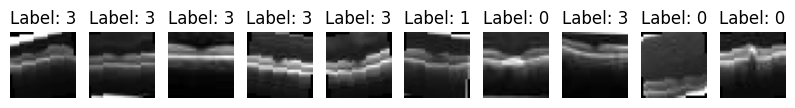

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(images, labels, num_samples=4):
    """
    Affiche des exemples d'images avec leurs étiquettes.

    Args:
        images: Un tableau NumPy contenant les images.
        labels: Un tableau NumPy contenant les étiquettes.
        num_samples: Le nombre d'échantillons à afficher.
    """
    # Vérification des entrées
    num_samples = min(num_samples, len(images))

    # Création de la figure
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 5))

    # Affichage des échantillons
    for i in range(num_samples):
        # Sélectionner un échantillon aléatoire
        index = np.random.randint(0, len(images))

        # Afficher l'image
        axes[i].imshow(images[index], cmap='gray')  # ou cmap='viridis', etc.
        axes[i].set_title(f"Label: {labels[index]}")
        axes[i].axis('off')  # Masquer les axes

    plt.show()
# Visualiser des exemples d'entraînement
visualize_samples(X_train, y_train, num_samples=10)

In [7]:
# Vérifier la distribution des classes
unique, counts = np.unique(y_train, return_counts=True)
print("Distribution des classes:", dict(zip(unique, counts)))

Distribution des classes: {0: 26830, 1: 8168, 2: 6213, 3: 36771}


In [8]:
from scipy.ndimage import rotate, shift

# Fonction pour effectuer des transformations manuelles
def random_rotate(image, angle_range=30):
    angle = np.random.uniform(-angle_range, angle_range)
    return rotate(image, angle, reshape=False, mode='nearest')

def random_flip(image):
    if np.random.rand() > 0.5:
        return np.fliplr(image)  # Inversion horizontale
    return image

def random_shift(image, max_shift=2):
    shift_x = np.random.uniform(-max_shift, max_shift)
    shift_y = np.random.uniform(-max_shift, max_shift)
    return shift(image, shift=(shift_x, shift_y), mode='nearest')

# Fonction pour augmenter les données
def augment_data(X_class, y_class, target_count):
    augmented_X = []
    augmented_y = []
    current_count = len(X_class)

    while len(augmented_X) + current_count < target_count:
        for i in range(current_count):
            image = X_class[i]

            # Appliquer des transformations aléatoires
            augmented_image = random_rotate(image)
            augmented_image = random_flip(augmented_image)
            augmented_image = random_shift(augmented_image)

            # Ajouter l'image augmentée
            augmented_X.append(augmented_image)
            augmented_y.append(y_class[i])

            if len(augmented_X) + current_count >= target_count:
                break

    return np.array(augmented_X), np.array(augmented_y)

# Filtrer les indices des classes 1 et 2
indices_class_1 = np.where(y_train == 1)[0]
indices_class_2 = np.where(y_train == 2)[0]

# Extraire les données des classes 1 et 2
X_class_1 = X_train[indices_class_1]
X_class_2 = X_train[indices_class_2]
y_class_1 = y_train[indices_class_1]
y_class_2 = y_train[indices_class_2]

# Déterminer combien d'échantillons ajouter
target_count = 25000

# Augmenter les données pour les classes 1 et 2
X_class_1_aug, y_class_1_aug = augment_data(X_class_1, y_class_1, target_count)
X_class_2_aug, y_class_2_aug = augment_data(X_class_2, y_class_2, target_count)

# Combiner les données d'origine et augmentées
X_train_augmented = np.concatenate((X_train, X_class_1_aug, X_class_2_aug), axis=0)
y_train_augmented = np.concatenate((y_train, y_class_1_aug, y_class_2_aug), axis=0)

# Mélanger les données après augmentation
indices = np.random.permutation(len(X_train_augmented))  # Générer des indices aléatoires
X_train_augmented = X_train_augmented[indices]
y_train_augmented = y_train_augmented[indices]

# Vérifier la nouvelle distribution des labels
unique, counts = np.unique(y_train_augmented, return_counts=True)
print(f"Nouvelle distribution des labels : {dict(zip(unique, counts))}")

Nouvelle distribution des labels : {0: 26830, 1: 25000, 2: 25000, 3: 36771}


In [9]:
# Standardisation des données
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train_augmented = (X_train_augmented - mean) / std
X_val = (X_val - mean) / std
X_test = (X_test - mean) / std

In [10]:
# Dimensions des données
num_classes = 4  # Nombre de classes
X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], -1)  # Aplatir les images à nouveau
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [11]:
def truncated_svd(X, n_components):
    """
    Réalise une réduction de dimension avec Truncated SVD sans centrer les données.

    Arguments:
    - X : ndarray, matrice d'entrée
    - n_components : int, nombre de composantes principales

    Retourne:
    - X_reduced : ndarray, matrice réduite
    - Vt_reduced : ndarray, composantes principales
    """
    # Vérifiez si X est une matrice valide
    X = np.asarray(X)

    # Calcul de la décomposition SVD
    U, S, Vt = np.linalg.svd(X, full_matrices=False)

    # Réduction à n_components
    U_reduced = U[:, :n_components]  # (n_samples, n_components)
    S_reduced = S[:n_components]     # (n_components,)
    Vt_reduced = Vt[:n_components, :]  # (n_components, n_features)

    # Calcul de la matrice réduite
    X_reduced = U_reduced * S_reduced  # Broadcasting (n_samples, n_components)

    return X_reduced, Vt_reduced

In [12]:
n_components = 100

# Réduction de dimension avec la fonction Truncated SVD sur X_train
X_train_reduced, Vt_train = truncated_svd(X_train_augmented, n_components)

# Transformation des données de validation en utilisant Vt_train
X_val_reduced = np.dot(X_val, Vt_train.T)

# Transformation des données de test
X_test_reduced = np.dot(X_test, Vt_train.T)

In [13]:
# Standardisation à nouveau aprés une réduction de dimension
X_train_reduced = (X_train_reduced - X_train_reduced.mean(axis=0)) / X_train_reduced.std(axis=0)
X_val_reduced = (X_val_reduced - X_train_reduced.mean(axis=0)) / X_train_reduced.std(axis=0)
X_test_reduced = (X_test_reduced - X_train_reduced.mean(axis=0)) / X_train_reduced.std(axis=0)

In [14]:
class LogisticRegressionMulticlass:
    def __init__(self, max_iter=1000, C=1.0, tol=1e-5, class_weight='balanced', learning_rate=0.01, num_classes=4):
        """
        Initialise les hyperparamètres du modèle de régression logistique multi-classes.

        Arguments:
        - max_iter : int, nombre maximum d'itérations pour l'optimisation
        - C : float, inverse de la force de régularisation (plus C est petit, plus la régularisation est forte)
        - tol : float, tolérance pour le critère d'arrêt
        - class_weight : str, option pour équilibrer les classes (si 'balanced', ajuste les poids de chaque classe)
        - learning_rate : float, taux d'apprentissage pour la descente de gradient
        - num_classes : int, nombre de classes (4 pour votre cas)
        """
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.class_weight = class_weight
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.models = {}  # Un modèle pour chaque classe

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_class_weights(self, y_binary):
        """
        Calcule les poids pour une classe binaire (dans le cadre OVA).
        """
        if self.class_weight == 'balanced':
            unique, counts = np.unique(y_binary, return_counts=True)
            class_weights = {cls: len(y_binary) / (2 * count) for cls, count in zip(unique, counts)}
            return np.vectorize(class_weights.get)(y_binary)
        else:
            return np.ones(len(y_binary))

    def train_one_vs_all(self, X, y_binary):
        """
        Entraîne un modèle de régression logistique binaire pour une classe donnée.
        """
        n_samples, n_features = X.shape
        weights = np.zeros(n_features + 1)  # Inclure le biais

        # Ajouter une colonne de 1 à X pour le biais
        X = np.c_[X, np.ones(n_samples)]

        # Poids pour les classes équilibrées
        sample_weights = self.compute_class_weights(y_binary)

        for _ in range(self.max_iter):
            # Calcul des prédictions
            z = np.dot(X, weights)
            predictions = self.sigmoid(z)

            # Calcul du coût et du gradient
            reg_term = (self.C / 2) * np.sum(np.square(weights[:-1]))
            cost = -(1 / n_samples) * np.sum(sample_weights * (y_binary * np.log(predictions) + (1 - y_binary) * np.log(1 - predictions))) + reg_term

            error = predictions - y_binary
            dw = (1 / n_samples) * np.dot(X.T, sample_weights * error)
            dw[:-1] += self.C * weights[:-1]  # Régularisation uniquement sur les poids (pas sur le biais)

            # Mise à jour des poids
            weights -= self.learning_rate * dw

            # Arrêt précoce
            if np.linalg.norm(dw) < self.tol:
                break

        return weights

    def fit(self, X, y):
        """
        Entraîne un modèle pour chaque classe (one-vs-all).
        """
        n_samples, n_features = X.shape

        for class_label in range(self.num_classes):
            # Convertir les labels pour la classe actuelle (1 pour la classe cible, 0 pour les autres)
            y_binary = (y == class_label).astype(int)
            print(f"Training model for class {class_label}...")
            self.models[class_label] = self.train_one_vs_all(X, y_binary)

    def predict(self, X):
        """
        Prédictions pour les données d'entrée X.
        """
        n_samples = X.shape[0]
        X = np.c_[X, np.ones(n_samples)]  # Ajouter une colonne de biais

        # Calculer les scores pour chaque classe
        scores = np.zeros((n_samples, self.num_classes))
        for class_label, weights in self.models.items():
            z = np.dot(X, weights)
            scores[:, class_label] = self.sigmoid(z)

        # Choisir la classe avec le score le plus élevé
        return np.argmax(scores, axis=1)

In [15]:
# Initialiser le modèle
logistic_regression = LogisticRegressionMulticlass(max_iter=1000, C=1.0, learning_rate=0.01, num_classes=4)

# Entraîner le modèle
logistic_regression.fit(X_train_reduced, y_train_augmented)

Training model for class 0...
Training model for class 1...
Training model for class 2...
Training model for class 3...


In [16]:
# Prédiction
y_pred_train = logistic_regression.predict(X_train_reduced)
y_pred_val = logistic_regression.predict(X_val_reduced)

# Évaluation
accuracy_train = np.mean(y_train_augmented == y_pred_train)
accuracy_val = np.mean(y_val == y_pred_val)
print(f"Accuracy on train set: {accuracy_train:.2f}")
print(f"Accuracy on validation set: {accuracy_val:.2f}")

Accuracy on train set: 0.52
Accuracy on validation set: 0.47


In [17]:
def compute_class_weights(y):
    """
    Calcule les poids des classes selon leur fréquence.
    """
    unique_classes, counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    weights = {cls: total_samples / (len(unique_classes) * count) for cls, count in zip(unique_classes, counts)}
    return weights

def svm_binary_fit(X, y, initial_learning_rate=0.01, C=1.0, epochs=1000, decay_rate=0.01, class_weights=None):
    """
    Entraîne un SVM binaire avec un learning rate décroissant, gestion des classes déséquilibrées,
    et suivi de l'accuracy par époque.
    """
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    b = 0
    accuracy_history = []

    for epoch in range(epochs):
        # Décroissance du learning rate
        learning_rate = initial_learning_rate / (1 + decay_rate * epoch)

        # Calcul des marges
        margins = y * (np.dot(X, w) + b)
        misclassified = margins < 1  # Identifie les mauvaises classifications

        if np.any(misclassified):  # Vérifiez si des échantillons sont mal classifiés
            # Appliquer les poids pour chaque échantillon mal classifié
            if class_weights is not None:
                weights = np.vectorize(class_weights.get)(y[misclassified])
            else:
                weights = np.ones_like(y[misclassified])

            # Gradient pondéré
            dw = w - C * np.dot((weights[:, None] * X[misclassified]).T, y[misclassified]) / n_samples
            db = -C * np.sum(weights * y[misclassified]) / n_samples
        else:
            # Si aucun échantillon mal classifié, utilisez uniquement la régularisation
            dw = w
            db = 0

        # Mise à jour
        w -= learning_rate * dw
        b -= learning_rate * db

        # Prédictions et calcul de l'accuracy
        predictions = np.sign(np.dot(X, w) + b)
        accuracy = np.mean(predictions == y)
        accuracy_history.append(accuracy)

    return w, b, accuracy_history

def svm_binary_predict(X, w, b):
    """
    Prédictions pour un SVM binaire.
    """
    return np.sign(np.dot(X, w) + b)

def one_vs_all_svm(X_train, y_train, num_classes, initial_learning_rate=0.01, C=1.0, epochs=1000, decay_rate=0.01):
    """
    Entraîne un SVM multi-classes en mode "one vs all" avec un learning rate décroissant et gestion des classes déséquilibrées.
    """
    models = {}
    accuracy_histories = {}
    for class_label in range(num_classes):
        # Convert labels to binary for "one vs all"
        y_binary = np.where(y_train == class_label, 1, -1)

        # Calcul des poids des classes
        class_weights = compute_class_weights(y_binary)

        # Entraîner le SVM binaire
        w, b, accuracy_history = svm_binary_fit(X_train, y_binary, initial_learning_rate, C, epochs, decay_rate, class_weights)
        models[class_label] = (w, b)
        accuracy_histories[class_label] = accuracy_history
    return models, accuracy_histories

def predict(X, models):
    """
    Prédictions pour un SVM multi-classes en mode "one vs all".
    """
    predictions = np.zeros((X.shape[0], len(models)))
    for class_label, (w, b) in models.items():
        predictions[:, class_label] = np.dot(X, w) + b
    return np.argmax(predictions, axis=1)

# Fonction de visualisation de l'accuracy
def plot_training_accuracy(accuracy_histories):
    """
    Trace l'évolution de l'accuracy pendant l'entraînement pour chaque classe.
    """
    plt.figure(figsize=(10, 6))
    for class_label, history in accuracy_histories.items():
        plt.plot(history, label=f"Class {class_label} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Over Epochs (One-vs-All)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
import time

# Dimensions des données
n_samples = X_train_reduced.shape[0]
n_features = X_train_reduced.shape[1]
num_classes = 4
epochs = 1000

# Petit échantillon pour estimation
sample_fraction = 0.01  # Utilisez 1% des données pour l'estimation
small_X = X_train_reduced[:int(n_samples * sample_fraction)]
small_y = y_train_augmented[:int(n_samples * sample_fraction)]

# Entraînement sur un petit échantillon
start_time = time.time()
_ = one_vs_all_svm(small_X, small_y, num_classes=num_classes, epochs=epochs, initial_learning_rate=0.01, C=1.0, decay_rate=0.01)
elapsed_time = time.time() - start_time

# Temps total estimé pour l'entrainement des données d'entraînement
estimated_total_time = elapsed_time / sample_fraction
print(f"Temps d'entraînement estimé : {estimated_total_time:.2f} secondes")

Temps d'entraînement estimé : 454.50 secondes


In [19]:
# Entraînement
models, accuracy_histories = one_vs_all_svm(X_train_reduced, y_train_augmented, num_classes=num_classes,
                                            initial_learning_rate=0.1, C=1.0, epochs=1000, decay_rate=0.1)

# Visualisation de l'évolution de l'accuracy
#plot_training_accuracy(accuracy_histories)

In [20]:
# Prédiction
y_pred_train = predict(X_train_reduced, models)
y_pred_val = predict(X_val_reduced, models)

# Évaluation
accuracy_train = np.mean(y_train_augmented == y_pred_train)
accuracy_val = np.mean(y_val == y_pred_val)
print(f"Accuracy on train set: {accuracy_train:.2f}")
print(f"Accuracy on validation set: {accuracy_val:.2f}")

Accuracy on train set: 0.52
Accuracy on validation set: 0.46


In [21]:
# Calcul du noyau polynomial avec sécurité contre les valeurs extrêmes
def polynomial_kernel_batch(X, Y, degree, coef0, batch_size=64):
    n_samples_X, n_samples_Y = len(X), len(Y)
    K = np.zeros((n_samples_X, n_samples_Y))
    for i in range(0, n_samples_X, batch_size):
        X_batch = X[i:i + batch_size]
        linear_component = np.dot(X_batch, Y.T)
        poly_component = (linear_component + coef0) ** degree
        K[i:i + batch_size, :] = np.clip(linear_component + poly_component, -1e3, 1e3)
    return K

# Entraînement d'un SVM binaire avec noyau polynomial par batch
def train_binary_svm_poly_batch(X, y, C, degree, coef0, max_iter=100, tol=1e-3, batch_size=64):
    n_samples, n_features = X.shape
    alpha = np.zeros(n_samples)
    b = 0

    for _ in range(max_iter):
        for i in range(0, n_samples, batch_size):
            batch_indices = range(i, min(i + batch_size, n_samples))
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            K_batch = polynomial_kernel_batch(X_batch, X, degree, coef0, batch_size)

            for j, idx in enumerate(batch_indices):
                margin = np.sum(alpha * y * K_batch[j]) + b
                if np.abs(margin) > 1e3:
                    margin = np.sign(margin) * 1e3
                if y[idx] * margin < 1:
                    alpha[idx] += C * (1 - y[idx] * margin)
                else:
                    alpha[idx] -= C * alpha[idx]
                alpha[idx] = np.clip(alpha[idx], 0, C)

        if np.linalg.norm(alpha - np.clip(alpha, 0, C)) < tol:
            break

    return alpha, b

# Entraînement multi-classe (OvR) avec noyau polynomial par batch
def train_svm_poly_ovr_batch(X, y, C, degree, coef0, max_iter=100, tol=1e-3, batch_size=64):
    n_classes = len(np.unique(y))
    models = {}
    for k in range(n_classes):
        y_k = np.where(y == k, 1, -1)
        alpha, b = train_binary_svm_poly_batch(X, y_k, C, degree, coef0, max_iter, tol, batch_size)
        models[k] = (alpha, b, y_k)
    return models

# Prédiction multi-classe avec noyau polynomial
def predict_svm_poly_ovr_batch(X_train, y_train, X_test, models, degree, coef0, batch_size=64):
    n_classes = len(models)
    n_test = len(X_test)
    scores = np.zeros((n_test, n_classes))

    for k, (alpha, b, y_k) in models.items():
        for i in range(0, n_test, batch_size):
            X_test_batch = X_test[i:i + batch_size]
            K_batch = polynomial_kernel_batch(X_test_batch, X_train, degree, coef0, batch_size)
            scores[i:i + batch_size, k] = np.sum(alpha * y_k * K_batch, axis=1) + b

    return np.argmax(scores, axis=1)

In [27]:
# Entraînement final sur tous les données ( entraînement et validation)
data_train = np.concatenate((X_train_reduced, X_val_reduced), axis=0)
label_train = np.concatenate((y_train_augmented, y_val), axis=0)

# Entraînement sur l'ensemble complet
models_final = logistic_regression.fit(data_train, label_train)

Training model for class 0...
Training model for class 1...
Training model for class 2...
Training model for class 3...


In [31]:
# Prédiction
predictions = logistic_regression.predict(X_test_reduced)

# Génération du fichier de soumission
submission = np.column_stack((np.arange(1, len(predictions) + 1), predictions))
np.savetxt('submission1.csv', submission, fmt='%d', delimiter=',', header='ID,Class', comments='')
print("Fichier de soumission généré : submission.csv")

Fichier de soumission généré : submission.csv


In [32]:
# Prédiction
y_pred = logistic_regression.predict(data_train)

# Évaluation
accuracy = np.mean(y_pred == label_train)
print(f"Accuracy on validation and train set: {accuracy:.2f}")

Accuracy on validation and train set: 0.51
